## **DAT 402 Project 1**   
## **Predicting Spotify Song Popularity**

**Team Members:**
- Pete VanBenthuysen
- Emily Szolnoki

**Project Goal:**
Predict whether a song will be popular (popularity $ \geq 70 $) based on its musical features, such as **danceability**, **energy**, and **tempo**. This project helps us identify which characteristics are most influential in determining whether a song becomes popular. We are most interested in analyzing and building a model to predict song popularity based on those musical attributes and more, allowing for potential insights in playlist curation and music production.

**Dataset:**
We are using a dataset from Kaggle called 'Spotify Tracks DB'. The raw dataset includes 18 columns and 232,725 rows with a mix of categorical and numerical features. There are also no missing values.

 (https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db)

**Columns:**
- **genre**: Genre of the song.
- **artist_name**: Name of the artist.
- **track_name**: Name of the track.
- **track_id**: Unique ID for each track.
- **popularity**: Popularity score of the song (ranging from 0 to 100).
- **acousticness**: A measure of how acoustic the song is (ranging from 0 to 1).
- **danceability**: How suitable the song is for dancing (ranging from 0 to 1).
- **duration_ms**: Duration of the trach in milliseconds.
- **energy**: A measure of energy, typically related to the intensity and activity of the track (ranging from 0 to 1).
- **instrumentalness**: A measure of whether the track is instrumental (ranging from 0 to 1).
- **key**: The musical key of the track.
- **liveness**: Measure of the presence of a live audience (ranging from 0 to 1).
- **loudness**: The overall loudness of the track in decibels.
- **mode**: The modality of the track.
- **speechiness**: Speechiness measure of the track (ranging from 0 to 1).
- **tempo**: The tempo (beats per minute) of the track.
- **time_signature**: The time signature of the track.
- **valence**: A measure of musical positiveness (ranging from 0 to 1).

### **Imports**

In [37]:
#%pip install pandas matplotlib seaborn scikit-learn imblearn

In [38]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection & evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    mean_squared_error,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    r2_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split as tts

# Preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

### **Data Loading and Cleaning**

After importing all necessary libraries, we begin the exploratory data analysis by loading in the dataset and taking a look at the first few rows to understand its structure. We also check for any missing values to assess data quality. These steps will ensure that our data is clean and ready for analysis and modeling.

In [39]:
# Load dataset
df = pd.read_csv("data/SpotifyFeatures.csv", parse_dates=False) # Set parse_dates=False to avoid parsing dates
print(df.head())

print(df.isnull().sum()) # Check for missing values

   genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#

Next, we check for duplicates in the dataset. Some songs appear multiple times in the dataset under the same **track_id** but with different genres. To create a more balanced and fair dataset, we remove all songs that have multiple occurrences of their **track_id**, excluding the first occurrence.

We identify the duplicates, assess how many rows were affected, include a sample of what a duplicated **track_id** looks like in the dataset, and remove them.

In [40]:
# Check for duplicate track_ids with different genres
dupes = df[df.duplicated(subset=['track_id'], keep=False)]
num_dupes = dupes['track_id'].nunique()
total_dupe_rows = dupes.shape[0]

print(f"\nFound {num_dupes} duplicated track_ids with conflicting genres.")
print(f"This affects a total of {total_dupe_rows} rows.\n")
print("Sample of duplicate conflicts:")
print(dupes[['track_id', 'track_name', 'genre']].sort_values(by='track_id').head(10))

before_dedup = df.shape[0]
# Remove duplicates based on track_id, keeping the first occurrence
df = df.drop_duplicates(subset='track_id', keep='first')
after_dedup = df.shape[0]

print(f"\nRemoved {before_dedup - after_dedup} duplicate rows based on track_id.\n")


Found 35124 duplicated track_ids with conflicting genres.
This affects a total of 91075 rows.

Sample of duplicate conflicts:
                      track_id           track_name             genre
14492   000xQL6tZNLJzIrtIgxqSl       Still Got Time             Dance
110840  000xQL6tZNLJzIrtIgxqSl       Still Got Time               Pop
96926   001gDjxhKGDSx4sMMAgS9R              Kingdom  Children’s Music
153533  001gDjxhKGDSx4sMMAgS9R              Kingdom              Rock
65253   001ifh9Zkyc5DhK7AGQRtK               Gemini              Folk
145387  001ifh9Zkyc5DhK7AGQRtK               Gemini             Indie
201614  002PgfoyfrOGiKch4EW8Wm    Jasmine Runs Away        Soundtrack
182413  002PgfoyfrOGiKch4EW8Wm    Jasmine Runs Away             Movie
121130  002QT7AS6h1LAF5dla8D92  Still Smell Like It               Rap
90714   002QT7AS6h1LAF5dla8D92  Still Smell Like It           Hip-Hop

Removed 55951 duplicate rows based on track_id.



The **time_signature** column describes the number of beats in a measure. We remove 
invalid time signatures (like '0/4') to clean up the data and improve the accuracy of the distribution. We also convert the column to a numeric format.

In [41]:
# Checking output of time_signature
print("Proportion of Each Value in 'time_signature':")
print(df['time_signature'].value_counts(normalize=True))

# Remove rows with invalid time signature and convert to integer
df = df[df['time_signature'] != '0/4']
df['time_signature'] = df['time_signature'].str.extract('(\d+)').astype(int)

Proportion of Each Value in 'time_signature':
time_signature
4/4    0.843942
3/4    0.117698
5/4    0.025060
1/4    0.013266
0/4    0.000034
Name: proportion, dtype: float64


To make the **duration_ms** feature more readable and intuitive, we create a new column called **duration_sec** to replace it.

In [42]:
# Convert duration from milliseconds to seconds for easier interpretation
df['duration_sec'] = df['duration_ms'] / 1000

The **genre** column had quite a few inconsistences. We perform the following steps to clean and consolidate it:
- Fix the apostrophe in **Children's Music**.
- Remove irrelevent genres like **Comedy** and **Children's Music** since they are outside the scope of our analysis.
- Combine **Rap** and **Hip-Hop** genres into one to create a more even distribution throughout genres.

In [43]:
# Fixing the genre name
df['genre'] = df['genre'].replace("Children’s Music", "Children's Music") 

# Dropping genres that are not relevant for our analysis
df = df[~df['genre'].isin(['Comedy', "Children's Music"])]

# Combine "Hip-Hop" and "Rap" into "Hip-Hop_Rap"
df['genre'] = df['genre'].replace({'Hip-Hop': 'Hip-Hop_Rap', 'Rap': 'Hip-Hop_Rap'})

# Check the updated genre distribution
print("Count of Each Genre in the Dataset:")
print(df['genre'].value_counts())

Count of Each Genre in the Dataset:
genre
Electronic     9149
Alternative    9095
Anime          8935
Hip-Hop_Rap    8869
Classical      8711
Reggae         8687
Reggaeton      8549
Blues          8496
Soundtrack     8480
Opera          8277
Folk           8048
Jazz           8039
Ska            8017
Dance          7981
World          7972
Movie          7802
Country        7383
R&B            5353
Soul           4430
Indie          3318
Pop            2417
Rock           2227
A Capella       119
Name: count, dtype: int64


To simplify the dataset, we drop columns that won't be used by the model:
- **track_name**, **track__id**, and **artist_name** are removed because they do not necessarily contribute meaningful predictive value. 
- **duration_ms** is removed because it was replaced by the new columns **duration_sec**.

Next, we define a threshold of 90% and a new binary target variable called **is_popular**. A song is considered popular if its popularity score falls within the top 10% of all of the songs in the dataset.

In [44]:
# Drop columns we don't want the model to use
df = df.drop(columns=['track_name', 'track_id', 'artist_name', 'duration_ms'])

# Statistically define threshold for popularity based on top 10%
threshold = df['popularity'].quantile(0.90) # Top 10%
df['is_popular'] = (df['popularity'] >= threshold).astype(int)
print(f"Using popularity threshold: {threshold:.2f}")
print("Class Distribution for 'is_popular' (Proportions):")
print(df['is_popular'].value_counts(normalize=True)) # Check class distribution



df = df.drop(columns=['popularity'])
df = df.drop_duplicates()

Using popularity threshold: 59.00
Class Distribution for 'is_popular' (Proportions):
is_popular
0    0.896766
1    0.103234
Name: proportion, dtype: float64


To wrap up the loading and cleaning of this dataset, we run some final quality checks to ensure everything is accurate and ready for exploratory analysis. We confirm that there are **no** missing values, our column data types are **appropriate**, the column names are **all** listed, there are **no** duplicates, and our dataset shape is **accurate**.

In [45]:
# Final quality checks
print("\n Quality checks:")
print("Missing values:\n")
print(df.isnull().sum())       # Check for missing values

print("\nData types:\n")
print(df.dtypes)               # Confirm correct data types

print("\nColumns in dataset:")
print(list(df.columns))        # Final column names

# Final duplicate check
num_duplicates = df.duplicated(keep=False).sum()
print(f"\nExact duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Sample duplicates:\n", df[df.duplicated(keep=False)].head(10))
else:
    print("No exact duplicate rows found.")

print(f"Cleaned dataset shape: {df.shape}")


 Quality checks:
Missing values:

genre               0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
duration_sec        0
is_popular          0
dtype: int64

Data types:

genre                object
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo               float64
time_signature        int64
valence             float64
duration_sec        float64
is_popular            int64
dtype: object

Columns in dataset:
['genre', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 

### **Exploratory Data Analysis**

We begin our EDA by examining summary statistics of our dataset. This will help us understand the scale and distribution of our features. We also take a look at the distribution of **time_signature** to understand the frequency of time signatures present in the songs.

In [46]:
### 1.5) EDA Checks ###

print(f"\nSummary statistics:\n{df.describe()}")  # Summary statistics
print(f"\nTime signature distribution:\n{df['time_signature'].value_counts(normalize=True)}")  # Categorical breakdown


Summary statistics:
        acousticness   danceability         energy  instrumentalness  \
count  159981.000000  159981.000000  159981.000000     159981.000000   
mean        0.376090       0.534982       0.554121          0.184452   
std         0.362517       0.193880       0.278229          0.330984   
min         0.000000       0.056900       0.000020          0.000000   
25%         0.037400       0.401000       0.338000          0.000000   
50%         0.236000       0.552000       0.592000          0.000154   
75%         0.740000       0.683000       0.787000          0.150000   
max         0.996000       0.987000       0.999000          0.999000   

            liveness       loudness    speechiness          tempo  \
count  159981.000000  159981.000000  159981.000000  159981.000000   
mean        0.196569     -10.020473       0.084368     118.181187   
std         0.171005       6.530106       0.093885      31.189596   
min         0.009670     -52.457000       0.022200    

The first chart we are taking a look at is the distribution of genres in the dataset. It is a great bar chart to visualize, as it helps us make interpretations for which genres dominate over others (specifically in this dataset after cleaning).

We see that genres **Electronic** and **Alternative** roughly make up 18,000 out of 159,981 songs in the cleaned dataset. **A Capella** has the least amount of songs out of all of the genres. While there aren't any noticeable imbalances (besides **A Capella**), seeing this distribution helps us visualize those imbalances and can help us consider stratification or balancing methods later on in the project.

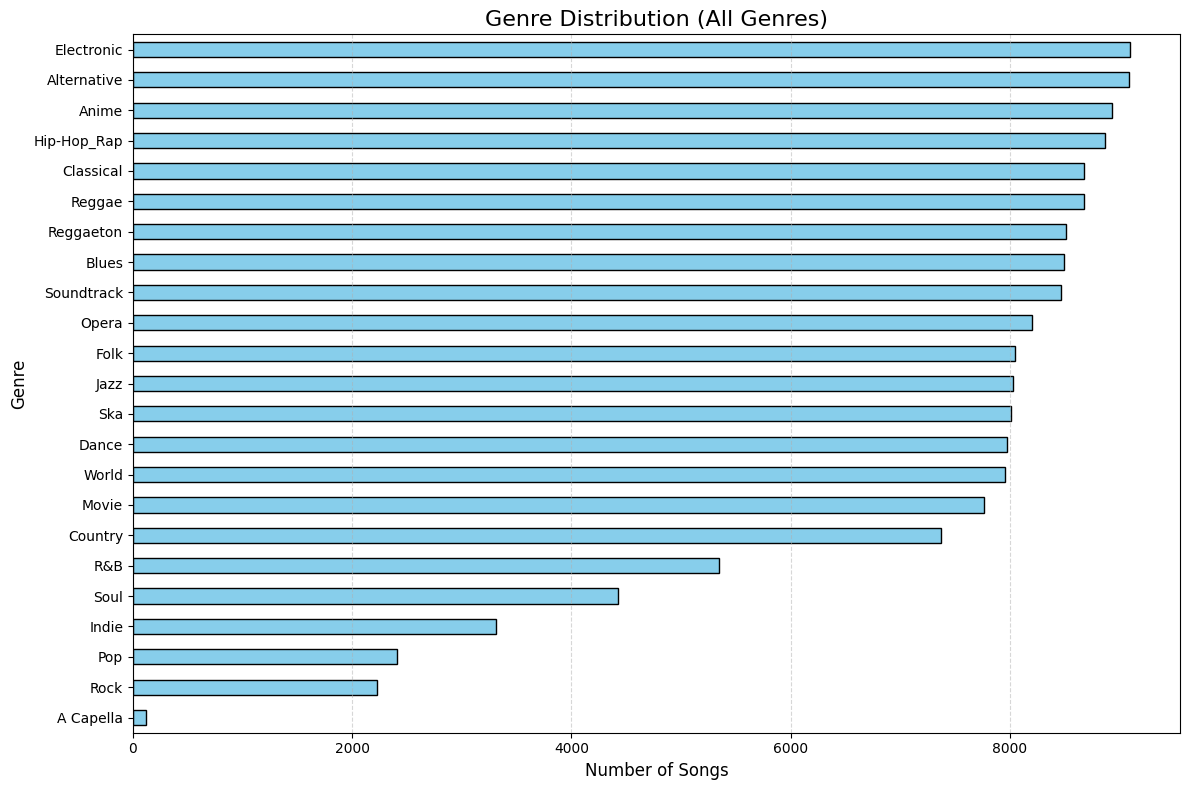

In [47]:
### 2) EDA ###

# Genre overview via bar chart
genre_counts = df['genre'].value_counts() # Count songs per genre
 
# Plot
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='barh', color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Genre Distribution (All Genres)', fontsize=16)
plt.xlabel('Number of Songs', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Flip the y-axis to show most common genres on top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()

To ensure that extremely short or long songs (duration of song) don't veer our analysis, we use an **Interquartile Range (IQR)** method to filter out those outliers. We use the **duration_sec** column to identify the length of those songs.

We calculate the IQR using the 25th percentile (Q1) and the 75th percentile (Q3). Any song that is outside of the IQR multiplied by 1.5 will be removed because they will be considered outliers in the dataset.

The IQR method is very helpful in our EDA because it helps us narrow down our dataset to focus on songs with more common durations.

We removed 9,888 songs. That is an impressive amount and will help our prediction models become more accurate.

In [48]:
# Save original count before filtering
original_count = df.shape[0]

# IQR calculation
Q1 = df['duration_sec'].quantile(0.25)
Q3 = df['duration_sec'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR 

# Filter using IQR
df = df[(df['duration_sec'] >= lower_bound) & (df['duration_sec'] <= upper_bound)]

# Count after filtering
filtered_count = df.shape[0]

# Show how many rows were removed
removed_count = original_count - filtered_count
print(f"Removed {removed_count} songs due to length outliers using IQR filtering.")
print(f"IQR Range: {lower_bound:.0f} to {upper_bound:.0f}")
print(f"Duration range after filtering: {df['duration_sec'].min():.3f} to {df['duration_sec'].max():.3f}")

Removed 9888 songs due to length outliers using IQR filtering.
IQR Range: 54 to 400
Duration range after filtering: 53.867 to 399.827



This boxplot shows how **tempo** varies across different genres. This helps us visualize which styles tend to be faster or slower.
- **Opera**, **Classical**, and **Soundtrack** genres have lower median tempos than all of the other genres. They also have wider ranges, which indicates diversity in musical structure.
- **Ska** (Jamaican and Caribbean rhythms) had the highest median tempo out of all of the genres. The entire range was the highest as well.
- **Dance** and **Electronic** genres had tighter distributions and higher median tempos. This makes sense, given these songs tend to be high-energy and ryhthm-focused.
- There is still a presense of outliers in almost all of the genres. This indicates that tempo can widely vary within genres.

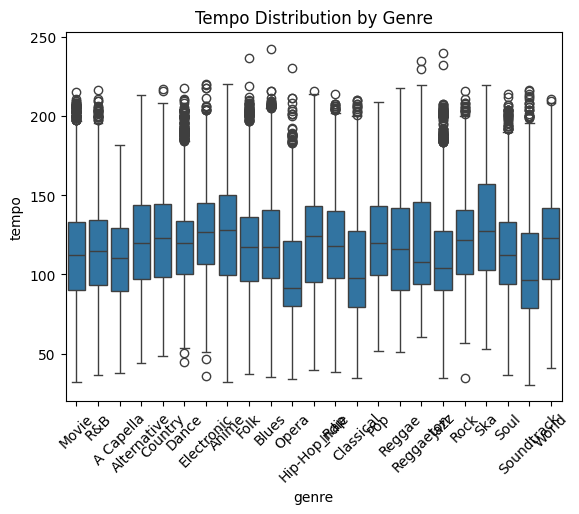

In [49]:
# Plot boxplot of song tempo by genre
sns.boxplot(x='genre', y='tempo', data=df)
plt.title('Tempo Distribution by Genre')
plt.xticks(rotation=45)
plt.show()

This histogram shows how **tempo** is distributed across all songs in the dataset.
- The first thing we notice is that there are several distinct peaks. We now know that the most common tempos within the songs are around **90**, **120**, and **140 BPM**.
- This suggests that there are certain tempos that are more popular than others, possibly because they align well with common rhythmic patterns are are ideal for dancing.
- There is more of a right-skewed tail, with some songs having higher tempos that exceed 200 BPM. There aren't many songs in this category, though.

This distribution definitely helps us identify the tempo range that songs tend to have and may help with determining if this is a factor for if a song is popular or not.

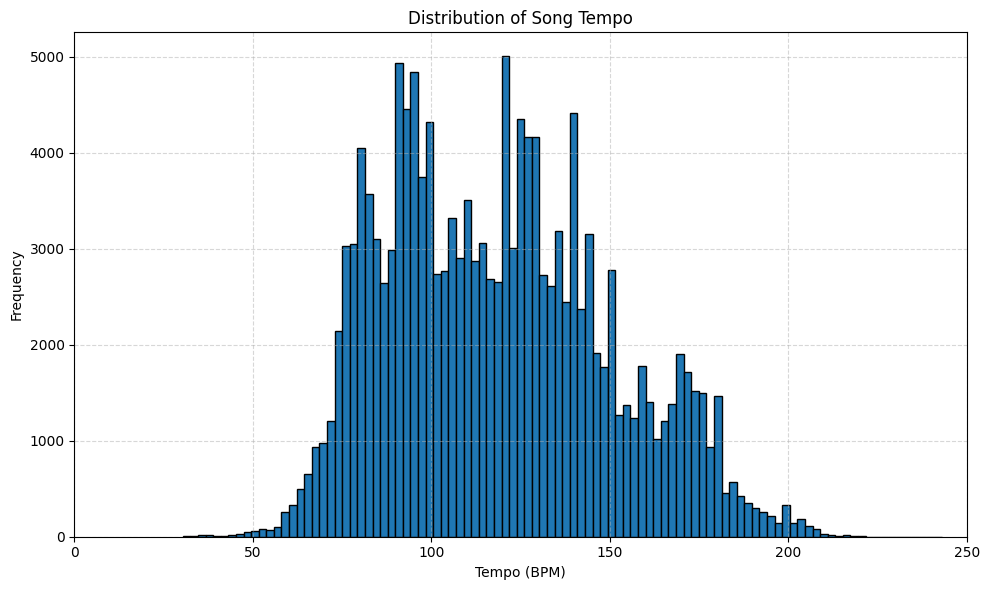

In [50]:
# Plot histogram of song tempo
plt.figure(figsize=(10, 6))
plt.hist(df['tempo'], bins=100, edgecolor='black')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Frequency')
plt.title('Distribution of Song Tempo')
plt.xlim(0, 250)  # Focus on songs between 0 and 250 BPM (common tempo range)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

After viewing two different graphs related to **tempo**, we will remove those outliers to further narrow down our dataset to improve accuracy. We will use an IQR calculation and follow the same steps as we did to filter out outliers in the **duration_sec** column. This step ensures that we are focusing on the most common tempo ranges relevant to mainstream genres.

After executing the code, we removed 67 songs from the dataset.

In [51]:
# Save original count before filtering
original_count = df.shape[0]

# IQR calculation for tempo
Q1 = df['tempo'].quantile(0.25)
Q3 = df['tempo'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR 

# Filter using IQR for tempo
df = df[(df['tempo'] >= lower_bound) & (df['tempo'] <= upper_bound)]

# Count after filtering
filtered_count = df.shape[0]

# Show how many rows were removed
removed_count = original_count - filtered_count
print(f"Removed {removed_count} songs due to tempo outliers using IQR filtering.")
print(f"IQR Range: {lower_bound:.0f} to {upper_bound:.0f}")
print(f"Tempo range after filtering: {df['tempo'].min():.3f} to {df['tempo'].max():.3f}")


Removed 67 songs due to tempo outliers using IQR filtering.
IQR Range: 24 to 210
Tempo range after filtering: 30.379 to 209.826


The next graph that we analyze is a violin plot to visualize the distribution of **energy** for both popular and non-popular songs (this is defined by the top 10% popullarity threshold).
- While both categories show a wide range of energy, popular songs tend to have slightly higher energy levels on average.
- The spread for non-popular songs is broader and more evenly spread out, including more low-energy tracks.

This violin plot suggests that a song must have higher energy for it to have a higher chance of becoming popular. This makes sense because most mainstream songs are very energetic. This would allow the song to cater to a wider audience.

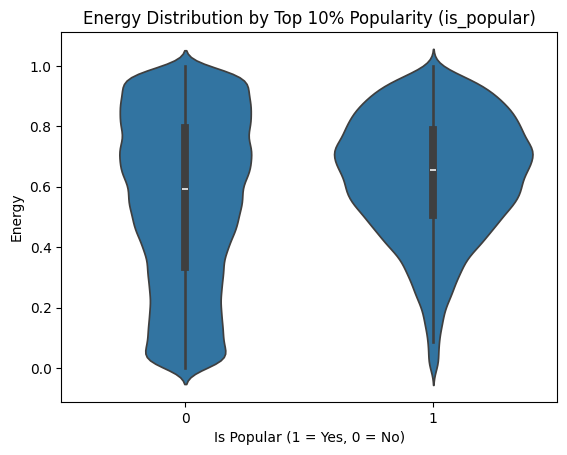

In [52]:
# Violin plot for is_popular vs energy
sns.violinplot(x='is_popular', y='energy', data=df)
plt.title('Energy Distribution by Top 10% Popularity (is_popular)')
plt.xlabel('Is Popular (1 = Yes, 0 = No)')
plt.ylabel('Energy')
plt.show()

We also calculate the IQR for both popular and non-popular songs. These numbers confirm that popular songs have a more consistent energy level, while non-popular songs tend to have a more diverse energy spread. This tells us that popularity might be associated with a specific energetic sound.

In [53]:
# Calculate IQR for energy based on is_popular
print("IQR (Popular):", df[df['is_popular'] == 1]['energy'].quantile(0.75) - df[df['is_popular'] == 1]['energy'].quantile(0.25))
print("IQR (Not Popular):", df[df['is_popular'] == 0]['energy'].quantile(0.75) - df[df['is_popular'] == 0]['energy'].quantile(0.25))

IQR (Popular): 0.281
IQR (Not Popular): 0.459


This scatter plot helps us see the relationship between **danceability** and **loudness** of songs in the dataset.

The Pearson correlation coefficient is **0.47**, which indicates a moderately positive relationship between these two variables. This means that louder songs do actually tend to be more danceable. However, that is only generally.
- Most songs fall within the loudness range of **-30 dB to 0 dB**.
- A few outliers exist in loudness, however, danceability scores are mostly between **0.4 and 0.8**.

This scatter plot suggests that there is definitely a correlation between danceability and loudness and will be useful features for analyzing and predicting song popularity.

Summary Statistics for Danceability:
count    150026.000000
mean          0.544035
std           0.190228
min           0.057000
25%           0.416000
50%           0.562000
75%           0.688000
max           0.987000
Name: danceability, dtype: float64

Summary Statistics for Loudness:
count    150026.000000
mean         -9.695339
std           6.339949
min         -52.457000
25%         -12.006000
50%          -7.685000
75%          -5.404000
max           3.744000
Name: loudness, dtype: float64


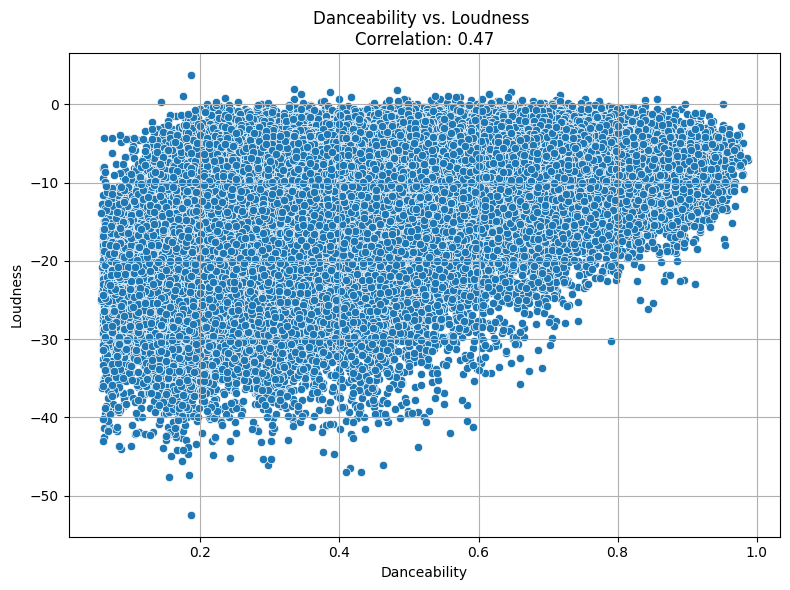

In [54]:
# Scatter plot for loudness vs. danceability
x = 'danceability'  # Defined variables
y = 'loudness'

corr_coeff = np.corrcoef(df[x], df[y])[0, 1] # Calculate the correlation coefficient

# Print summary statistics for both features
print(f"Summary Statistics for {x.capitalize()}:")
print(df[x].describe())
print(f"\nSummary Statistics for {y.capitalize()}:")
print(df[y].describe())

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=df)

# Annotate the plot with the correlation coefficient
plt.title(f'{x.capitalize()} vs. {y.capitalize()} \nCorrelation: {corr_coeff:.2f}')
plt.xlabel(x.capitalize())
plt.ylabel(y.capitalize())
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

This scatter plot displays the relationship between **loudness** and **energy**. 

The Pearson correlation coefficient is **0.84**, which is very strong and positive! This means that as loudness increases, energy tends to increase. This applies to a very large chunk of songs that are in the dataset, aside from a few outliers. This makes sense because as loudness increases, songs usually feel more energetic and intense.
- There is a steep upward trend in energy as loudness increases from **-30 dB to 0 dB**.
- The distribution is more spread out at lower loudness levels but gets tighter once it reaches higher energy.

This is a strong relationship and suggests that loudness is a very strong predictor of energy in this dataset.

Summary Statistics for Loudness:
count    150026.000000
mean         -9.695339
std           6.339949
min         -52.457000
25%         -12.006000
50%          -7.685000
75%          -5.404000
max           3.744000
Name: loudness, dtype: float64

Summary Statistics for Energy:
count    150026.000000
mean          0.565377
std           0.274093
min           0.000020
25%           0.361000
50%           0.605000
75%           0.794000
max           0.999000
Name: energy, dtype: float64


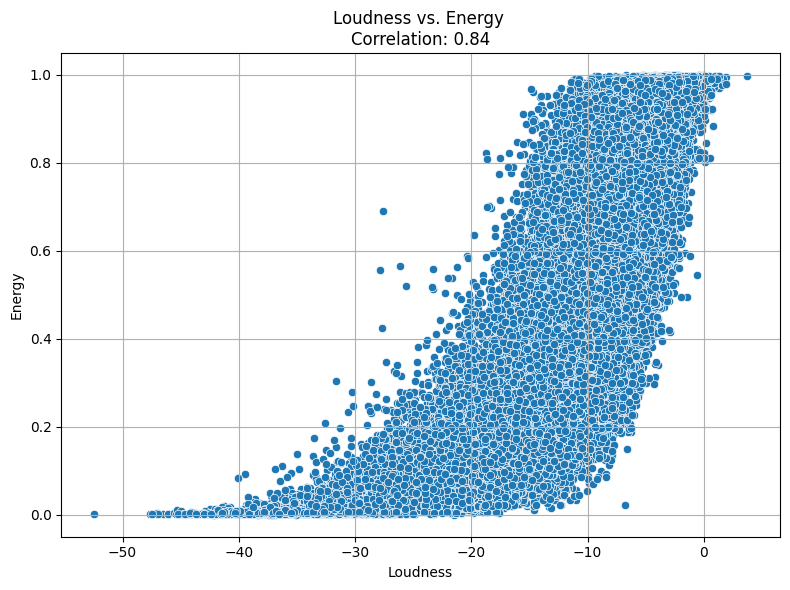


Correlation between loudness and energy: 0.84


In [55]:
# Scatter plot for loudness vs energy
x = 'loudness' # Defined variables
y = 'energy'

# Calculate the correlation coefficient
corr_coeff = np.corrcoef(df[x], df[y])[0, 1]

# Print summary statistics for both features
print(f"Summary Statistics for {x.capitalize()}:")
print(df[x].describe())
print(f"\nSummary Statistics for {y.capitalize()}:")
print(df[y].describe())

# Plot the scatter plot of loudness vs energy
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, data=df)

# Annotate the plot with the correlation coefficient
plt.title(f'{x.capitalize()} vs. {y.capitalize()} \nCorrelation: {corr_coeff:.2f}')
plt.xlabel(x.capitalize())
plt.ylabel(y.capitalize())
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Print the correlation coefficient
print(f"\nCorrelation between {x} and {y}: {corr_coeff:.2f}")

Our final visualization is a correlation matrix. This heatmap displays the correlation coefficients between all of the numerical features in our dataset. 
- It is very prominent that **energy** and **loudness** have a strong positive correlation. This aligns with our "Loudness vs. Energy" scatter plot!
- **Danceability** and **valence** have the next higheset correlation coefficient. This suggests that there is a moderate correlation to happier songs being more danceable.
- **Acousticness** and **energy** are very negatively correlated. This means that songs that are acoustic tend to be quieter and less energetic, which makes sense as well.

This matrix gives us great insight! It allows us to spot which features may be redundant and which are most predictive for modeling.

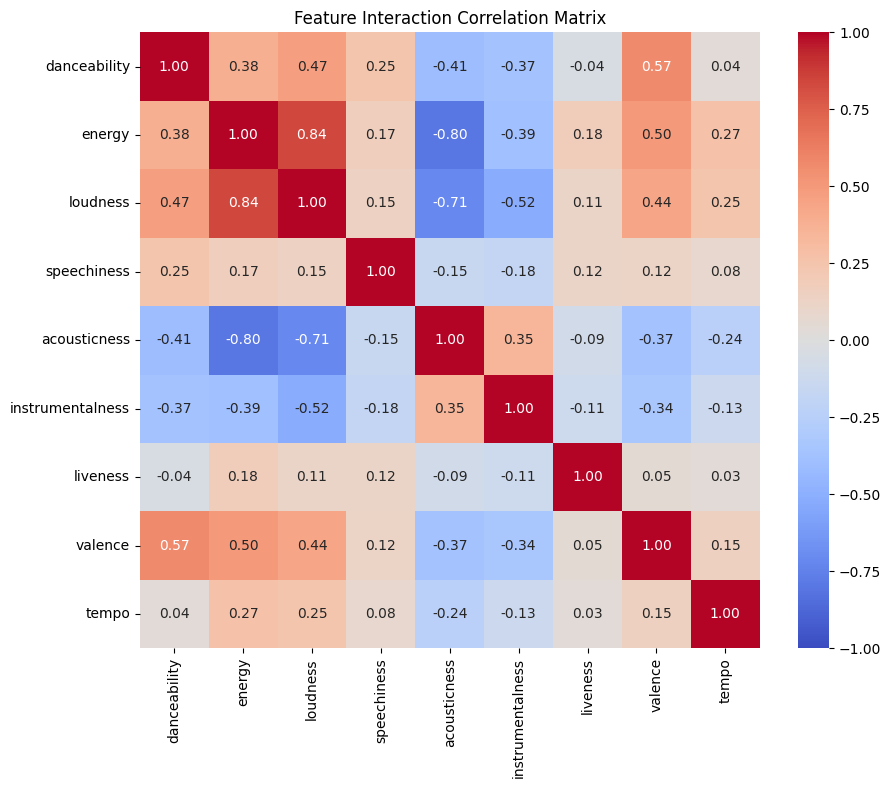

In [56]:
# Calculate pairwise correlation of features
corr_matrix = df[['danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Feature Interaction Correlation Matrix')
plt.show()

In [57]:
# Data point check
print(f"After EDA and cleaning, the final dataset contains {df.shape[0]:,} songs.")

After EDA and cleaning, the final dataset contains 150,026 songs.


### **Training and Testing Data**

To prepare our dataset for modeling, we split the data into 3 parts:
- Training set
- Validation set
- Test set

First, we split the dataset into **train_val** (80%) and **test** (20%). Stratifying by **is_popular** ensures that it maintains its class balance.

Second, we split the **train_val** portion into **train** (75%) and **validation** (25%) using stratification.

We also defined our **feature columns** by selecting all numeric columns except for **is_popular** because it is our target variable.

This setup allows us to train the model, tune hyperparameters, and evaluate generalizability on separate data splits.

After splitting, we successfully have a 60/20/20 split. This gives us a solid foundation for training and tuning.

In [58]:
### 3) Training/Testing Dataset Using Train/Validation/Test For Baseline Model ###

# First split: 80% train_val, 20% test
train_val_df, test_df = tts(
    df, test_size=0.2, stratify=df['is_popular'], random_state=42
)

# Second split: 75% train, 25% val from train_val
train_df, val_df = tts(
    train_val_df, test_size=0.25, stratify=train_val_df['is_popular'], random_state=42
)

# Define feature columns (drop the target)
feature_cols = train_df.select_dtypes(include='number').columns.drop('is_popular')

# X and y for training set
X_train = train_df[feature_cols]
y_train = train_df['is_popular']

# Validation set
X_val = val_df[feature_cols]
y_val = val_df['is_popular']

# Test set
X_test = test_df[feature_cols]
y_test = test_df['is_popular']

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (90015, 11)
Validation size: (30005, 11)
Test size: (30006, 11)


We trained a **Baseline Linear Regression** model using the training set and evaluated its performance on the validation set. 

Linear Regression is very helpful as a baseline to gauge how well our features will explain the likelihoood of a song becoming popular.

**Performance:**
- **R² Score**: 0.048
- - This score suggests that this model explains only about 4.8% of the variance in song popularity.
- **Mean Squared Error**: 0.093
- - The MSE score is relatively high. This is indicating that the predicted values deviate significantly from the actual binary labels.

These scores confirm that linear regression isn't the best fit for classification, but it gives us a great start.

In [59]:
### 3.5) Baseline Model With Linear Regression ###

# Initialize and train model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict on validation set
y_val_pred = linreg.predict(X_val)

# Evaluate model performance
print("Linear Regression - R² Score:", r2_score(y_val, y_val_pred))
print("Linear Regression - MSE:", mean_squared_error(y_val, y_val_pred))

Linear Regression - R² Score: 0.04721113262187737
Linear Regression - MSE: 0.0922222193839378


### **Feature Engineering**

We applied several transformations to prepare our dataset for model training:
- Converted the **mode** column from string values to binary values.
- One-hot encoded the **genre** and **key** columns too preserve their meaning without introducing order.
- Created a new feature column called **vocalness** that analyzes the vocal-heaviness of a song, rather than its instrumentalness.
- Binned and one-hot encoded a new feature column called **tempo_category** from **tempo** into three categories: slow, medium, and fast. 
- Dropped **instrumentalness** and **tempo** to avoid duplication.

We also calculated another correlation matrix that included our target variable, **is_popular**.
- **Loudness** and **energy** remain very highly correlated.
- **Vocalness** appears to be moderately correlated with our target variable.

This feature engineering enhances our model performance by introducing interpretability and reducing noise.

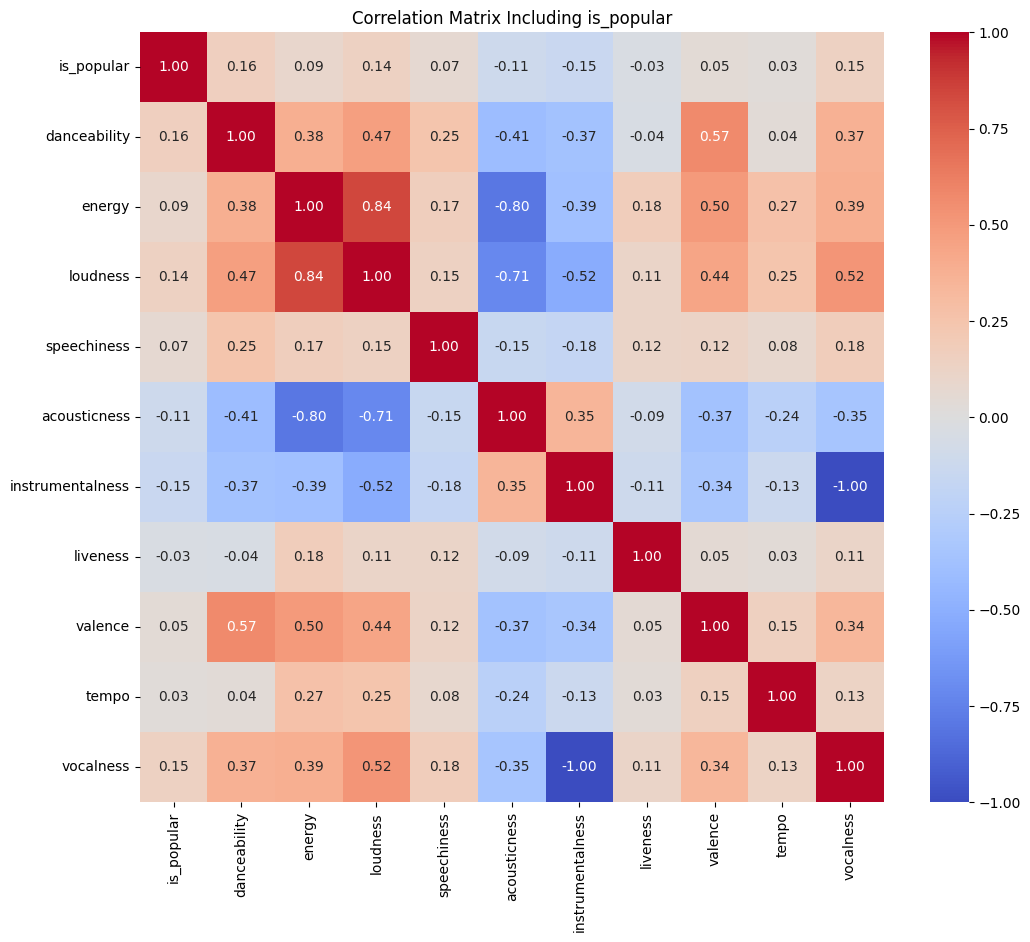

In [60]:
### 4) Feature Engineering ###

# Convert mode from string to binary: Major = 1, Minor = 0
df['mode'] = df['mode'].map({'Minor': 0, 'Major': 1})

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['genre', 'key'])

# Create a new feature for vocalness as the inverse of instrumentalness (more vocals = less instrumental)
df['vocalness'] = 1 - df['instrumentalness']

# Bin tempo into categories: slow, medium, fast
df['tempo_category'] = pd.cut(
    df['tempo'],
    bins=[0, 90, 120, float('inf')],
    labels=['slow', 'medium', 'fast']
)

# One-hot encode tempo_category
df = pd.get_dummies(df, columns=['tempo_category'])

# Calculate correlation matrix including the target variable
corr_matrix = df[['is_popular', 'danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                  'vocalness']].corr()
                  
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix Including is_popular')
plt.show()

# Drop the original instrumentalness column
df.drop(columns=['instrumentalness'], inplace=True)

# Drop the original tempo column to avoid redundancy
df.drop(columns=['tempo'], inplace=True)

Before we proceed with modeling, we performed a few quick data quality checks to ensure the dataset is clean and ready!

We verified that there are no missing values or duplicates in any column.

After feature engineering, our dataset now contains 150,026 songs and confirms that it is well-structured and ready for building predictive models.

In [61]:
# Data checkpoint after feature engineering
print("Checking for missing values in the dataset...") # Check for missing values in each column
missing_values = df.isnull().sum()
print("Missing values by column:")
print(missing_values) 
print("Checking for duplicate rows in the dataset...") # Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"After feature engineering, the dataset contains {df.shape[0]:,} songs.")

Checking for missing values in the dataset...
Missing values by column:
acousticness             0
danceability             0
energy                   0
liveness                 0
loudness                 0
mode                     0
speechiness              0
time_signature           0
valence                  0
duration_sec             0
is_popular               0
genre_A Capella          0
genre_Alternative        0
genre_Anime              0
genre_Blues              0
genre_Classical          0
genre_Country            0
genre_Dance              0
genre_Electronic         0
genre_Folk               0
genre_Hip-Hop_Rap        0
genre_Indie              0
genre_Jazz               0
genre_Movie              0
genre_Opera              0
genre_Pop                0
genre_R&B                0
genre_Reggae             0
genre_Reggaeton          0
genre_Rock               0
genre_Ska                0
genre_Soul               0
genre_Soundtrack         0
genre_World              0
key_A     

Next, we split the cleaned and feature-engineered dataset into 3 new **training**, **validation**, and **test** sets the same way that we did during the first split.

We have another 60/20/20 split.

In [62]:
### 4.5) Setting Up New Train/Validation/Test Sets After Feature Engineering ###

# First split: 80% train_val, 20% test
train_val_df, test_df = tts(
    df, test_size=0.2, stratify=df['is_popular'], random_state=42
)

# Second split: 75% train, 25% val from train_val
train_df, val_df = tts(
    train_val_df, test_size=0.25, stratify=train_val_df['is_popular'], random_state=42
)

# Define feature columns (drop the target)
feature_cols = train_df.select_dtypes(include='number').columns.drop('is_popular')

# X and y for training set
X_train = train_df[feature_cols]
y_train = train_df['is_popular']

# Validation set
X_val = val_df[feature_cols]
y_val = val_df['is_popular']

# Test set
X_test = test_df[feature_cols]
y_test = test_df['is_popular']

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (90015, 11)
Validation size: (30005, 11)
Test size: (30006, 11)


### **Rescaling the Data**


Now, we are rescaling our data set so that we can have a more accurate prediction on whether a song will become popular or not. It is important that we standardize our dataset because, for example, **tempo** (ranging from 30 to 250) would overpower **energy** (ranging from 0 to 1) if we didn't rescale so this is definitely an important step.

Because this dataset is imbalanced, we use SMOTE to balance the training data. We created two separate SMOTE-resampled datasets:
- One for **Logistic Regression**
- One for **Random Forest**

This process prepares both models for fair training without being biased toward the majority class.

In [63]:
### 5) Rescaling Training Data ###

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the training data
scaler.fit(X_train)

# Transform the training data using the fitted scaler
X_train_scaled = scaler.transform(X_train)

# Transform the validation and test data using the same scaler (no fitting, just transforming)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print the first few rows of the scaled data to ensure it looks correct
print("Scaled Training Data (first few rows):")
print(X_train_scaled[:5])

# Create separate SMOTE objects for each model to avoid overwriting
sm = SMOTE(random_state=42)

# Resample scaled data for Logistic Regression
X_train_resampled_lr, y_train_resampled_lr = sm.fit_resample(X_train_scaled, y_train)

# Resample unscaled data for Random Forest
X_train_resampled_rf, y_train_resampled_rf = sm.fit_resample(X_train, y_train)

Scaled Training Data (first few rows):
[[-0.91956141 -0.47320354  0.78720612 -0.13108128  0.9702682  -1.36124939
  -0.38365909  0.24315219 -0.64425865 -0.25942396  0.52846787]
 [-0.97813239 -1.2974761   1.51594897  2.94634503  0.84651793  0.73461925
  -0.37065865  0.24315219  1.25129923 -0.64903957  0.52628452]
 [-0.90386775 -0.18444564  0.97303555  0.07169487  0.68754522  0.73461925
  -0.27640546  0.24315219  0.41381409  1.6878622   0.52044037]
 [ 0.16161969 -0.11094363 -0.37149501 -0.52470558 -0.50828805  0.73461925
  -0.48332913  0.24315219 -0.77137693 -0.09255675  0.52846787]
 [-0.12422912  1.11233985 -0.12736616 -0.60879804 -0.30151346 -1.36124939
  -0.48657924  0.24315219  1.41954401  1.15311699 -1.69861684]]


/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/emilyszolnoki/envs/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


This code reveals the **is_popular** feature column before and after oversampling.

In [64]:
print("Before oversampling:", np.bincount(y_train))
print("After oversampling for Logistic Regression:", np.bincount(y_train_resampled_lr))
print("After oversampling for Random Forest:", np.bincount(y_train_resampled_rf))

Before oversampling: [80239  9776]
After oversampling for Logistic Regression: [80239 80239]
After oversampling for Random Forest: [80239 80239]


### **Training and Tuning Candidate Models**

Now that our data is cleaned, engineered, and balanced, we move into training and evaluating predictive models.

We begin with **Logistic Regression** as a strong, interpretable baseline. We use **GridSearchCV** to tune hyperparameters for 3 different solver configurations, aiming to maximize the **F1 Score**:
- **liblinear**
- **saga**
- **lbfgs**

The models were trained using the rescaled training set using 5-fold cross-validation. It is being evaluated using **F1 Score**, which balances precision and is important in our case.

The model that had the highest F1 score was the **liblinear** Solver. It had an F1 Score of 0.6994 and was saved as our best performing logistic regression model.

In [ ]:
### 6) Train/Tune Candidate Models ###

# Logistic Regression Model

# Define multiple Logistic Regression solver configurations
logreg_models = [
    {
        'model': LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced'),
        'params': {
            'penalty': ['l1', 'l2'],
            'C': [0.01, 0.1, 1, 10, 100]
        }
    },
    {
        'model': LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced'),
        'params': [
            {
                'penalty': ['l1', 'l2'],
                'C': [0.01, 0.1, 1, 10, 100]
            },
            {
                'penalty': ['elasticnet'],
                'C': [0.01, 0.1, 1, 10, 100],
                'l1_ratio': [0.0, 0.5, 1.0]  # Only for elasticnet
            }
        ]
    },
    {
        'model': LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced'),
        'params': {
            'penalty': ['l2'],
            'C': [0.01, 0.1, 1, 10, 100]
        }
    }
]

# Loop through each configuration and run GridSearchCV
best_score = 0
best_model = None
best_params = None

for config in logreg_models:
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train_resampled_lr, y_train_resampled_lr)
    
    print(f"Solver: {config['model'].solver}")
    print("Best Params:", grid.best_params_)
    print("Best CV F1 Score:", grid.best_score_)
    print("-" * 40)
    
    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_params = grid.best_params_

# Save the best performing model
best_logreg = best_model

print("Best Logistic Regression Model (Key Parameters):")
print(best_logreg)

After training a baseline Logistic Regressioin model, we now explore a **Random Forest Classifier**. 

To optimize the Random Forest, we use **RandomizedSearchCV** to evaluate different combinations of hyperparameters.

Our Random Forest model went through randomized hyperparameter tuning with 25 configurations evaluation using 5-fold cross-validation.

The best perfoming model was found with the following parameters:
- **n_estimators**: 200
- **min_samples_split**: 2
- **max_depth**: None
- **max_features**: 'sqrt'
- **class_weight**: 'balanced'

This configuration achieved a cross-validation F1 Score of **0.8549**. This makes it a strong candidate compared to the Logistic Regression model.

In [ ]:
#Random Forest Model
# Define the parameter distributions for Random Forest
param_dist_rf = {
    'n_estimators': [50, 100, 200],         # Number of trees
    'max_depth': [None, 5, 10, 20],         # Depth of trees
    'min_samples_split': [2, 5, 10],        # Min samples to split
    'max_features': ['sqrt',] #'log2', None]  # Feature subset at each split
}

# Initialize RandomizedSearchCV with Random Forest
random_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist_rf,
    n_iter=25,                  # Try 25 random combinations
    cv=5,                       # 5-fold cross-validation
    scoring='f1',               # F1-score for binary classification
    n_jobs=-1,                  # Use all available CPU cores
    verbose=1,                  # Show progress
    random_state=42             # Reproducibility
)

# Fit the model on the training data (no scaling needed for Random Forest)
random_rf.fit(X_train_resampled_rf, y_train_resampled_rf)

# Output the best hyperparameters and best cross-validation score
print("Best parameters for Random Forest:", random_rf.best_params_)
print("Best cross-validation F1 score for Random Forest:", random_rf.best_score_)

# Save the best model for future use
best_rf = random_rf.best_estimator_

print("Best Random Forest Model (Key Parameters):")
print(best_rf)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': None}
Best cross-validation F1 score for Random Forest: 0.8548788958123952
Best Random Forest Model (Key Parameters):
RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)


Now, we will evaluate both models (Logistic Regression and Random Forest) on the validation set before chooosing the final model for testing. This step is important to see how well the models generalize to unseen data.


We will be calculating key metrics such as:
- **F1 Scores**
- **Precision**
- **Recall**
- **Accuracy**

We will also experiment with different classification thresholds to understand how model performance changes when the decision boundary is adjusted.

In [67]:
### 6.5) Evaluating Tuned Models on the Validation Set ###

# Making predictions on the validation set

# Function to plot threshold metrics
def plot_threshold_metrics(thresholds, f1_scores, precisions, recalls, accuracies, title='Metric Performance vs. Classification Threshold'):
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, accuracies, label='Accuracy', marker='o')
    plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
    plt.title(title)
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

After training and tuning our Random Forest model, we evaluated its performance on the **validation set** by varying the classification threshold.

We looped through multiple thresholds and calculated key metrics at each level.

The best threshold for the Random Forest model, by F1 Score, is **0.30**. We find that at this threshold, **precision** is a 0.18. This is low, but expected in an imbalanced dataset. 

Overall, this model does a good job at identifying most of the **truly** popular songs because of its high **recall** at 70%. This could be valuable if we want to prioritize the discovery of potential hits, even at the cost of false alarms.



In [68]:
# Random Forest: Threshold Tuning

# Get predicted probabilities from the random forest model
y_val_probs_rf = best_rf.predict_proba(X_val)[:, 1]

# Store metrics for different thresholds
thresholds_rf = np.arange(0.1, 0.9, 0.05)
f1_scores_rf, precisions_rf, recalls_rf, accuracies_rf = [], [], [], []

for thresh in thresholds_rf:
    y_pred_thresh_rf = (y_val_probs_rf >= thresh).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_thresh_rf, average='binary')
    acc = accuracy_score(y_val, y_pred_thresh_rf)

    precisions_rf.append(precision)
    recalls_rf.append(recall)
    f1_scores_rf.append(f1)
    accuracies_rf.append(acc)

# Find best threshold based on F1 score
best_idx_rf = np.argmax(f1_scores_rf)
best_threshold_rf = thresholds_rf[best_idx_rf]
print(f"\nBest threshold for Random Forest (by F1-score): {best_threshold_rf:.2f}")
print(f"Precision: {precisions_rf[best_idx_rf]:.2f}, Recall: {recalls_rf[best_idx_rf]:.2f}, F1: {f1_scores_rf[best_idx_rf]:.2f}, Accuracy: {accuracies_rf[best_idx_rf]:.2f}")

# Make final predictions using the best threshold
y_val_pred_rf_thresh = (y_val_probs_rf >= best_threshold_rf).astype(int)

# Final Random Forest Validation Performance
print("\nRandom Forest - Validation Set Performance (Threshold = {:.2f}):".format(best_threshold_rf))
print(classification_report(y_val, y_val_pred_rf_thresh))


Best threshold for Random Forest (by F1-score): 0.30
Precision: 0.18, Recall: 0.70, F1: 0.28, Accuracy: 0.61

Random Forest - Validation Set Performance (Threshold = 0.30):
              precision    recall  f1-score   support

           0       0.94      0.60      0.73     26747
           1       0.18      0.70      0.28      3258

    accuracy                           0.61     30005
   macro avg       0.56      0.65      0.51     30005
weighted avg       0.86      0.61      0.69     30005




This plot shows how dfferent classificatoin thresholds affect the key metrics on the validation set for the **Random Forest** model.
- As the threshold increases, the model becomes more conservative, labeling fewer songs as popular.
-  - This leads to **higher precision** but **lower recall**.
- **Accuracy** continuess to improve as the threshold increases because the non-popular songs are being predicted more often.
- The **F1 Score** peaks at **0.3**, which indicates the most effective cutoff for detecting popular songs.

It helps to use a custom threshold to maximize detecting of top 10% popular songs while balancing false alarms.

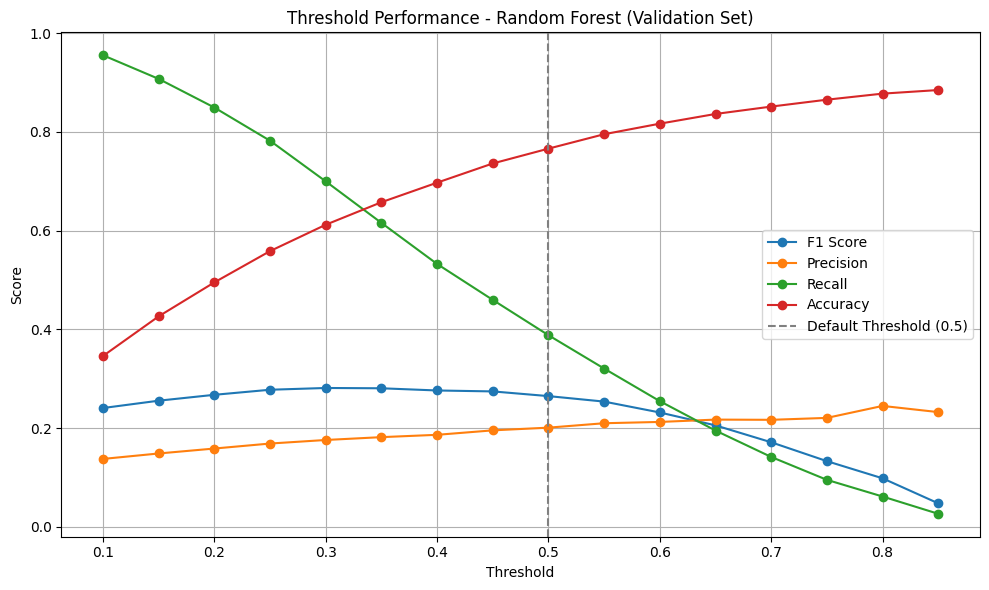

In [ ]:
# Plot F1, precision, recall, and accuracy vs. threshold
plot_threshold_metrics(
    thresholds_rf,
    f1_scores_rf,
    precisions_rf,
    recalls_rf,
    accuracies_rf,
    title='Threshold Performance - Random Forest (Validation Set)'
)

Next, we evaluated our **Logistic Regression** performance using the same key metrics as the Random Forest model (F1 score, precision, recall, and accuracy) on the validation set.

The best threshold for the Logistic Regressioin model, based on F1 Score, is **0.60**. 

Compared to the Random Forest model, Logistic Regression achieves slightly **better** precision but **lower** recall. This means it is even more conservative in predicting popularity.

The **accuracy** is higher, though, because most songs are not popular.

In [69]:
# Logistic Regression: Threshold Tuning

# Get predicted probabilities from logistic regression model
y_val_probs = best_logreg.predict_proba(X_val_scaled)[:, 1]

# Store metrics for different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores, precisions, recalls, accuracies = [], [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_val_probs >= thresh).astype(int)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_thresh, average='binary')
    acc = accuracy_score(y_val, y_pred_thresh)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    accuracies.append(acc)

# Find best threshold based on F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\nBest threshold (by F1-score): {best_threshold:.2f}")
print(f"Precision: {precisions[best_idx]:.2f}, Recall: {recalls[best_idx]:.2f}, F1: {f1_scores[best_idx]:.2f}, Accuracy: {accuracies[best_idx]:.2f}")

# Make final predictions using the best threshold
y_val_pred_lr = (y_val_probs >= best_threshold).astype(int)

# Final Logistic Regression Validation Performance
print("\nLogistic Regression - Validation Set Performance (Threshold = {:.2f}):".format(best_threshold))
print(classification_report(y_val, y_val_pred_lr))


Best threshold (by F1-score): 0.60
Precision: 0.21, Recall: 0.50, F1: 0.30, Accuracy: 0.75

Logistic Regression - Validation Set Performance (Threshold = 0.60):
              precision    recall  f1-score   support

           0       0.93      0.78      0.84     26747
           1       0.21      0.50      0.30      3258

    accuracy                           0.75     30005
   macro avg       0.57      0.64      0.57     30005
weighted avg       0.85      0.75      0.79     30005



Compared to the Random Forest threshold performance chart, the chart for **Logistic Regression** has a lot of the same patterns! The overall line shape that the different thresholds take are very similar to each other.

Of course, this chart shows how different classification thresholds impact our key metrics for the **Logistic Regression** model on the validation set.
- As the threshold increases, **precision** increases but **recall** decreases.
- The **F1 Score** peaks at around threshold of **0.6**. This is quite a balanced trade-off between precision and recall.
- **Accuracy** increases as the threshold increases.

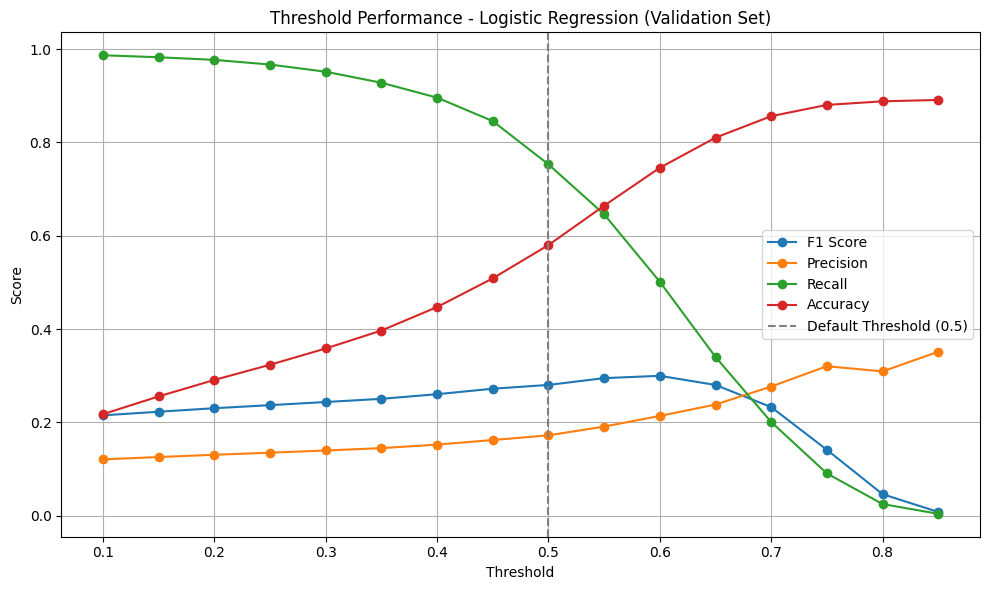

In [70]:
# Plot F1, precision, recall, and accuracy vs. threshold
plot_threshold_metrics(
    thresholds,
    f1_scores,
    precisions,
    recalls,
    accuracies,
    title='Threshold Performance - Logistic Regression (Validation Set)'
)

# Function to plot the confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Popular', 'Popular'],
                yticklabels=['Not Popular', 'Popular'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


So far, we've explored a range of thresholds to determine the best balance between our key metrics (F1 score, precision, recall, and accuracy).

We also visualized how performance meetrics change across threesholds. We plotted **confusion matrices** for both models to examine the classificatiob performance in more detail!

These insights help us understand each model's trade-off and guide us in selecting the best model for the final test evaluation.

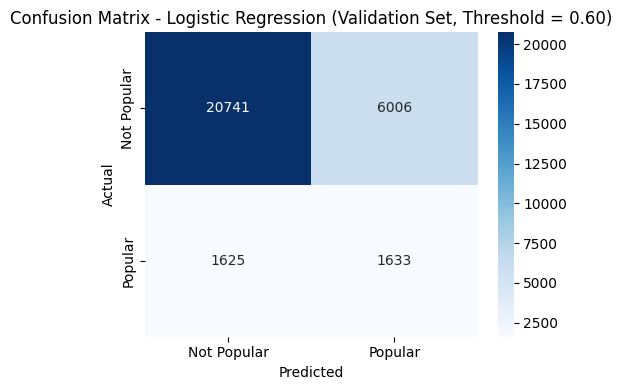

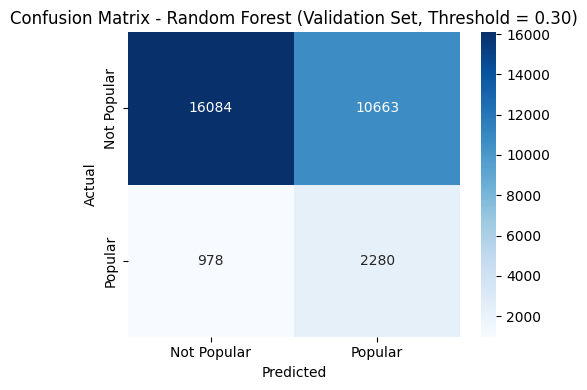

In [71]:
# Confusion matrices at optimized thresholds
plot_conf_matrix(
    y_val,
    y_val_pred_lr,
    f"Confusion Matrix - Logistic Regression (Validation Set, Threshold = {best_threshold:.2f})"
)

plot_conf_matrix(
    y_val,
    y_val_pred_rf_thresh,
    f"Confusion Matrix - Random Forest (Validation Set, Threshold = {best_threshold_rf:.2f})"
)

### **Characterizing Model Performance on Testing Dataset**

After fine-tuning and validating the **Random Forest** model, we will assess its performance on the **test set** using the threshold = **0.30** from the validation phase.

This evaluation provides a realistic estimate of how the model will perform in production.
- The model maintains a **high recall** of 68%, meaning it correctly identifies most of the truly **popular songs**.
- Its **low precision** indicates a considerable number of false positives.

The final trade-off suggests that the model captures **popularity broadly**, but would need refinement for a more precise prediction. However, these insights help solidify the **Random Forest** model's strengths and limitations.

In [ ]:
### 7) Characterizing random forest model performance on testing set ###

# 1. Predict probabilities and apply threshold
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= best_threshold_rf).astype(int)

# 2. Evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Confusion matrix + specificity
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
specificity_rf = tn_rf / (tn_rf + fp_rf)

# Print results
print(f"Random Forest - Test Set (Threshold = {best_threshold_rf:.2f}):")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Sensitivity (Recall): {recall_rf:.4f}")
print(f"Specificity: {specificity_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

Random Forest - Test Set (Threshold = 0.30):
Accuracy: 0.6103
Sensitivity (Recall): 0.6786
Specificity: 0.6020
Precision: 0.1720
F1 Score: 0.2744



The confusion matrix highlights the model's bias toward classifying songs as popular, leading to a high number of false positives.

The ROC curve for the **Random Forest** test set provides a visual summary of the model's biased ability. An AUC of **0.69** indicates a moderate performance. This suggests that the model is somewhat effectve at distinguishing popular songs from non-popular songs.

The model shows a lot of potential, especially in **recall**, but **precision** trade-offs should be considered.

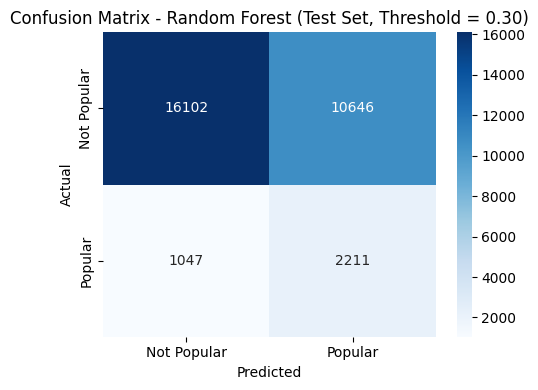

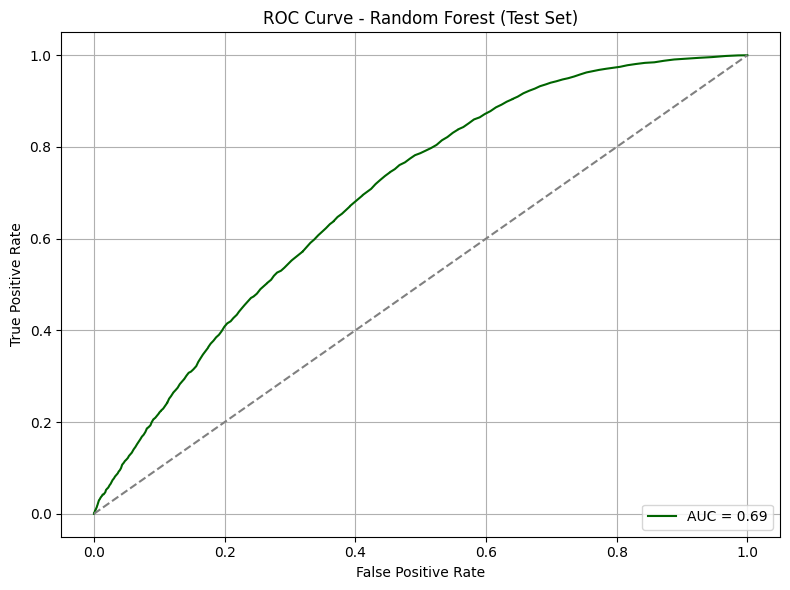

In [ ]:
# Plot confusion matrix
plot_conf_matrix(
    y_test,
    y_pred_rf,
    f"Confusion Matrix - Random Forest (Test Set, Threshold = {best_threshold_rf:.2f})"
)

# ROC Curve for Random Forest
def plot_roc_curve(y_true, y_prob, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkgreen')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot it
plot_roc_curve(
    y_test,
    y_prob_rf,
    title=f'ROC Curve - Random Forest (Test Set)'
)